# LOW RANK ALGORITHM FOR NON-LINEAR SCHRODINGER EQUATION

This notebook shows how to apply low rank algorithms to the resolution of non linear Schrödinger equation (see below)

First we import the librairies required

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from celluloid import Camera
%matplotlib inline
plt.rcParams["figure.figsize"] = 6,4

Sources used in this notebook : 

**1)** _Computational Methods in Applied Mathematics | Volume 19: Issue 1_
Projection Methods for Dynamical Low-Rank Approximation of High-Dimensional Problems             

Emil Kieri and Bart Vandereycken
https://www.degruyter.com/view/journals/cmam/19/1/article-p73.xml

**2)**_Numerical Resolution Of The Schrödinger Equation_

Loren Jørgensen, David Lopes Cardozo, Etienne Thibierge
https://web.pa.msu.edu/people/duxbury/courses/phy480/SchrodingerDynamics.pdf

**3)**_Streaming Low-Rank Matrix Approximation with an Application to Scientific Simulation_

Joel A. Tropp, Alp Yurtsever, Madeleine Udell, Volkan Cevher
https://arxiv.org/pdf/1902.08651.pdf

**4)**_Exact solutions of the nonlinear Schrödinger equation by the first integral method_

N.Taghizadeh, M.Mirzazadeh, F.Farahrooz
https://www.sciencedirect.com/science/article/pii/S0022247X10007031

## THE NON LINEAR SCHRODINGER EQUATION

We want to solve this differential equation on a two dimensional domain : 
    
$\mathrm{i} \dot{A}=-\frac{1}{2}(B A+A B)-\alpha|A|^{2} A$

where

$A:[0, T] \rightarrow \mathbb{C}^{n \times n}$

$B=\operatorname{tridiag}{(1,0,1)}$

With the initial data 

$A_{j, k}(0)=\exp \left(-\frac{\left(j-\mu_{1}\right)^{2}}{\sigma^{2}}-\frac{\left(k-\nu_{1}\right)^{2}}{\sigma^{2}}\right)+\exp \left(-\frac{\left(j-\mu_{2}\right)^{2}}{\sigma^{2}}-\frac{\left(k-\nu_{2}\right)^{2}}{\sigma^{2}}\right)$

and

$\sigma=10, \mu_{1}=60, \mu_{2}=50, \nu_{1}=50, \text { and } \nu_{2}=40$

To work in the complex field, we need to import cmath

In [135]:
import cmath

First, we want to create the fonction representing the integrator (the function **integrator**). Note that we put the i on the right hand side by multiplying by -i on each side. Since there is a tridiagonal matrix, we need a function to tridiagonalise a matrix **tridiag**

In [136]:
def tridiag(a, b, c, k1=-1, k2=0, k3=1):
    return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)

alpha=0.5

def integrator(A):
    #Inputs : A is the matrix A at the time t
    #Return : dA(t)
    
    size=A.shape ; n=size[0] ; a=1*np.ones(n-1) ; b=np.zeros(n) ; B=tridiag(a,b,a)
    
    I=np.identity(n) ; c=complex(-1j) ; I_c=c*I
    
    d=alpha*((A.conj().T)**2)
    
    m=A@B+B@A ; n=d@A
    
    dA=I_c@(-(1/2)*m+n)
    
    return dA

Now we want to compute the Runge Kutta Scheme. We use Runge Kutta of order 4

In [137]:
def rk4_solver(A0,integrator,t_range,h):
    #Runge Kutta Solver 
    #Input : A0, initial value matrix, integrator : integrator function, t_range : time interval,
    #h : time step
    #Output : [tsol, Asol], tsol : time, Asol : associated solution to tsol
    
    #---------------- initialisation
    
    n = int((t_range[-1] - t_range[0])/h)
    
    Asol=[]
    Asol.append(A0) #0 step
    
    tsol=[]
    tsol.append(t_range[0])
    
    for i in range(n):
        
        A=Asol[i]
        t=tsol[i]
        
        #---------------------- weight
        
        k1=integrator(A)
        k2=integrator(A+h/2*k1)
        k3=integrator(A+h/2*k2)
        k4=integrator(A+h*k3)
        
        
        approx=A+(h/6)*(k1+2*k2+2*k3+k4) #RK4 shema

        
        Asol.append(approx)
                              
        t += h # Increase x-step
        
        tsol = np.append(tsol, t)   
        
    return [tsol,Asol]

Now we create a version using an randomized algorithm (here STA, see source 3) )

We first define the low-rank algorithm STA19, adapted for the case of complex field

In [138]:
def sta(r,A,k,s):
    #INPUTS:
    #r : truncated final rank
    #A : matrix to approximate (MxN)
    #Dim_redux : (KxM), (KxN), (SxM), (SxN)
    #OUTPUTS : 
    #A_tilda : approximate matrix of rank r0
    #////plan
    #1. recuperation of the dim_red from the array
    #2. capturing the range, corange, and the new whole 
    #3. qr to get the orthonormal matrix
    #4. least square
    #5. reconstruct the svd after troncature
    #6. reconstruction
    
    #1. recuption of the dim_red from the array and initiation of X,Y,Z,W
    #(KxM), (KxN), (SxM), (SxN)
    
    m,n =A.shape
    Y_=np.random.normal(size=(k,m))+complex(1j)*np.random.normal(size=(k,m))
    Ω=np.random.normal(size=(k,n))+complex(1j)*np.random.normal(size=(k,n))
    Φ=np.random.normal(size=(s,m))+complex(1j)*np.random.normal(size=(s,m))
    Ψ=np.random.normal(size=(s,n))+complex(1j)*np.random.normal(size=(s,n))
    
    #2. capturing the range, corange, and the new whole 
    
    X=Y_@A ; Y=A@Ω.conj().T ; Z=Φ@A@(Ψ.conj().T) ; 
    
    #3. qr 
    
    Q=np.linalg.qr(Y)[0] ; P=np.linalg.qr(X.conj().T)[0]
    
    #4. least square
    
    C=np.linalg.lstsq(Φ@Q,Z, rcond=None)[0]
    C=(np.linalg.lstsq(Ψ@P,C.conj().T, rcond=None)[0]).conj().T
    
    #5. troncated svd + consolidation
    
    S, D, Vt=np.linalg.svd(C, full_matrices=True)
    S=S[:,0:r] ; D=np.diag(D[0:r]) ; Vt=Vt[0:r,:]
    S=Q@S ; Vt=Vt@(P.conj().T)
    
    #6. reconstruction
    
    Trunc_svd=[S,D,Vt]
    A_tilda=S@D@Vt
    
    return(A_tilda, Trunc_svd)

Then we create the solver

In [139]:
def rk4_solver_lr_sta(A0,integrator,t_range,h,r,k,s):
    #Runge Kutta Solver 
    #Inputs : A0 is initial value, integrator is the integrator, t_range is the time range, 
    #h is the time step, r is the aimed rank for each projection, k,s are the dim redux parameter
    #Outputs : [tsol,Asol] solutions at each time in tsol
    
    n = int((t_range[-1] - t_range[0])/h)
    
    Asol=[]
    Asol.append(sta(r,A0,k,s)[0]) #0 step
    
    tsol=[]
    tsol.append(t_range[0])
    
    for i in range(n):
        
        A=Asol[i]
        t=tsol[i]
        
        #---------------------- weight
        
        k1=integrator(A)
        k2=integrator(A+h/2*k1)
        k3=integrator(A+h/2*k2)
        k4=integrator(A+h*k3)
        
        
        approx=A+(h/6)*(k1+2*k2+2*k3+k4) #RK4 shema

        
        Asol.append(sta(r,approx,k,s)[0])
                              
        t += h # Increase x-step
        
        tsol = np.append(tsol, t)   
        
    return [tsol,Asol]

We compare the algorithm toward the solution found with the rk4 solver without low rank. We compute the relative error.

We create the initial matrix

In [140]:
n=20
size=n
A0=np.zeros((n,n))

sigma=10 ; c1=60 ; c2=50 ; v1 = 50 ; v2=40

for j in range(n):
    for k in range(n):
        m1=(-(j-c1)**2-(k-v1)**2)/(sigma**2) ; m2=(-(j-c2)**2-(k-v2)**2)/(sigma**2)
        A0[j,k]=np.exp(m1)+np.exp(m2)*10**6

Then compute the relative error between the approximation by STA19 and the value obtained trough the standard RK4 sheme

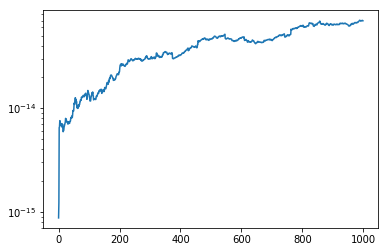

In [141]:
t_range = [0,1]
h = 0.001
m = int((t_range[1]-t_range[0])/h)

err_norm=[]

r=3 ; k=4 ; s=6 ;

sta_sol=rk4_solver_lr_sta(A0,integrator,t_range,h,r,k,s)[1]
sol_rk4=rk4_solver(A0,integrator,t_range,h)[1]

for i in range(m):
    err_norm.append(np.linalg.norm(sol_rk4[i]-sta_sol[i])/np.linalg.norm(sol_rk4[i]))

plt.semilogy(err_norm)

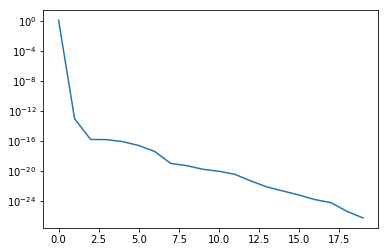

In [143]:
plt.semilogy(np.linalg.svd(sol_rk4[1])[1])

Now we want to compare with other algorithm 

In [144]:
def svd_r(A,r):
    #INPUTS : 
    #A = matrix to troncate
    #r = rank 
    #OUTPUT : 
    #M = matrix final 
    
    U,D,Vt = np.linalg.svd(A, full_matrices=True)
    U=U[:,0:r] ; Vt=Vt[0:r,:] ; D=np.diag(D[0:r])
    finale=U@D@Vt
    
    return(finale,[U,D,Vt])

In [145]:
def hmt_fixed_r(M,parameters):
    #INPUTS : 
    #M = Matrix MxN to approximate
    #parameters=(r,k,q)
    #---r = final rank
    #---k = dim redux size
    #---q = parameter 
    #OUTPUTS : 
    #M_r = Matrix with approximated rank
    #U_r = troncated singular vector matrix
    
    #Drawing a dim redux matrix
    
    r=parameters[0] ; k=parameters[1] ; q=parameters[2]
    
    m=M.shape[0]
    n=M.shape[1]

    Omega=np.random.normal(size=(n,k))+complex(1j)*np.random.normal(size=(n,k))
    
    if q==0:
        
        Y=M@Omega
    
    if q==1:
        
        Y=M@(M.conj().T@(M@Omega))
        
    if q==2:
        
        Y=M@(M.conj().T@(M@(M.conj().T@(M@Omega))))
             
    Q,R=np.linalg.qr(Y)
        
    B=Q.conj().T@M
        
    U,D,Vh=np.linalg.svd(B,full_matrices=True)
    
    U=U[:,0:r]
    
    D=D[0:r]
    
    Vh=Vh[0:r,:]

    U=Q@U
        
    M_r=U@np.diagflat(D)@Vh
        
    U_r=U
    
    return(M_r,U_r)

In [146]:
def tcyu(M,parameters):
    #INPUTS : 
    #M = matrix to approximate
    #parameters = (r,k,l)
    #---r = wanted rank
    #---k,l = k<l (parameter)
    #OUTPUTS : 
    #M_tilde = wanted matrix
    
    r=parameters[0] ; k=parameters[1] ; l=parameters[2]
    
    m=M.shape[0]
    n=M.shape[1]
    
    Y_tilde=np.random.normal(size=(l,m))+complex(1j)*np.random.normal(size=(l,m))
    Ω=np.random.normal(size=(k,n))+complex(1j)*np.random.normal(size=(k,n))
    
    X=Y_tilde@M
    Y=M@(Ω.conj().T)
    
    Q, R=np.linalg.qr(Y)
    
    B=np.linalg.lstsq(Y_tilde@Q, X,rcond=None)[0]
    
    U, D, Vh = np.linalg.svd(B, full_matrices=True)
    
    U=U[:,0:r] ; D=D[0:r] ; Vh=Vh[0:r,:]
    
    Q_tilde=Q@U
    
    M_tilde=U@np.diagflat(D)@Vh
    
    M_tilde=Q@M_tilde
    
    return(M_tilde,Q_tilde)

In [147]:
def feval(funcName, *args):

    return eval(funcName)(*args)

In [148]:
def rk4_solver_lr_method(A0,t_range,h,method, parameters):
    #INPUTS : A0 :  initial matrix - t_range : time range - h : step size - method : method to use
    #between svd, hmt, tcyu - parameters : parameters for the method 
    #OUTPUTS : Solutions [tsol, Asol]
    
    
    n = int((t_range[-1] - t_range[0])/h)
    
    Asol=[]
    evaluation=feval(method,A0,parameters)[0]
    Asol.append(evaluation) #0 step
    
    tsol=[]
    tsol.append(t_range[0])
    
    for i in range(n):
        
        A=Asol[i]
        t=tsol[i]
        
        #---------------------- weight
        
        k1=integrator(A)
        k2=integrator(A+h/2*k1)
        k3=integrator(A+h/2*k2)
        k4=integrator(A+h*k3)
        
        
        
        approx=A+(h/6)*(k1+2*k2+2*k3+k4) #RK4 shema

        evaluation=feval(method,approx,parameters)[0]
        
        Asol.append(evaluation)
                              
        t += h # Increase x-step
        
        tsol = np.append(tsol, t)   
        
    return [tsol,Asol]

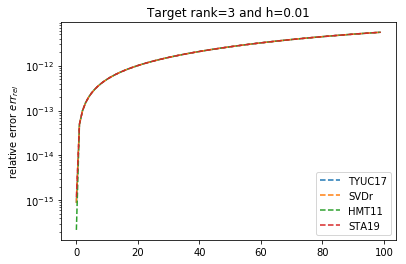

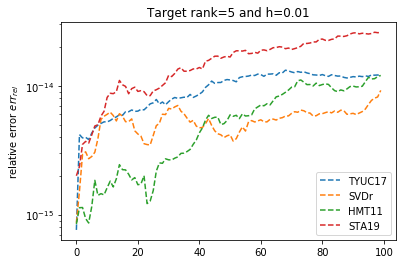

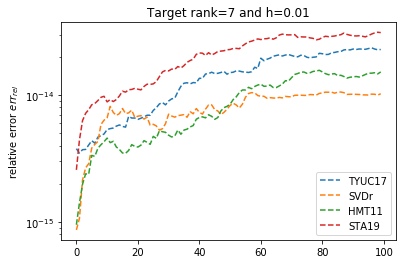

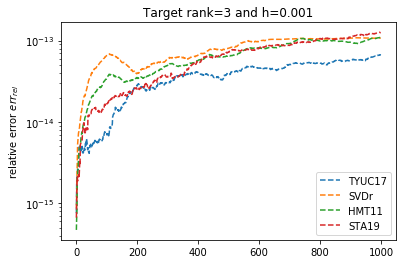

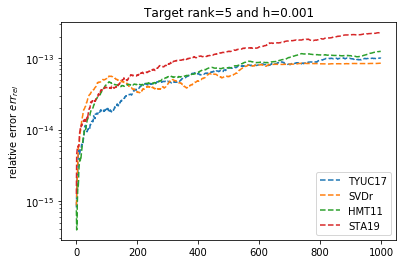

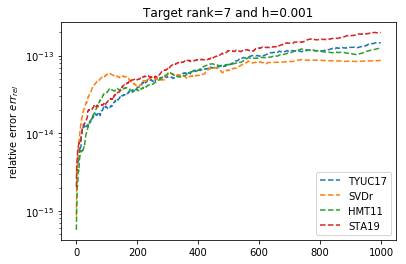

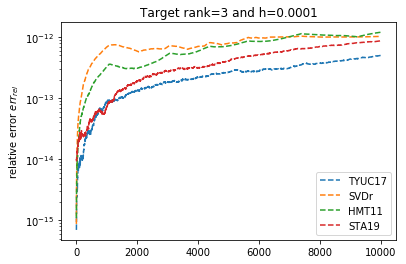

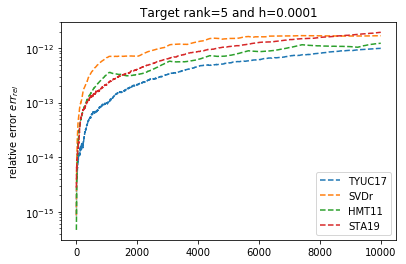

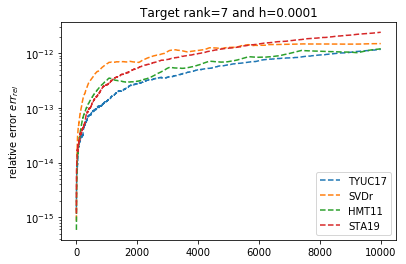

In [152]:
r_array=[3,5,7]

for j in range(3):

    for r in range(3):
    
        err_hmt=[]
        err_tcyu=[]
        err_svd=[]
        err_sta=[]

        t_range = [0,1]
        h = 0.01*10**-j
        m = int((t_range[1]-t_range[0])/h)



        r=r_array[r] ; k=2*r ; s=4*r ;

        tcyu_sol=rk4_solver_lr_method(A0,t_range,h,'tcyu', [r,k,s])[1]
        svd_sol=rk4_solver_lr_method(A0,t_range,h,'svd_r', (r))[1]
        hmt_sol=rk4_solver_lr_method(A0,t_range,h,'hmt_fixed_r', (r,k,0))[1]
        sta_sol=rk4_solver_lr_sta(A0,integrator,t_range,h,r,k,s)[1]
        sol_rk4=rk4_solver(A0,integrator,t_range,h)[1]


        for i in range(m):
            err_tcyu.append(np.linalg.norm(sol_rk4[i]-tcyu_sol[i])/np.linalg.norm(sol_rk4[i]))
            err_svd.append(np.linalg.norm(sol_rk4[i]-svd_sol[i])/np.linalg.norm(sol_rk4[i]))
            err_hmt.append(np.linalg.norm(sol_rk4[i]-hmt_sol[i])/np.linalg.norm(sol_rk4[i]))
            err_sta.append(np.linalg.norm(sol_rk4[i]-sta_sol[i])/np.linalg.norm(sol_rk4[i]))

        plt.figure()
        plt.semilogy(err_tcyu,'--',label='TYUC17')
        plt.semilogy(err_svd,'--',label='SVDr')
        plt.semilogy(err_hmt,'--',label='HMT11')
        plt.semilogy(err_sta,'--',label='STA19')
        plt.legend()
        plt.title('Target rank='+str(r) + ' and h=' + str(h))
        plt.ylabel('relative error $err_{rel}$')

Calculation of error for different steps size

In [154]:
result=np.zeros((5,4,5))
approx_result=np.zeros((5,4))

r_array=[2,3,4,5,7]
h_array=[0.01,0.005,0.001,0.0005,0.0001]

for w in range(5):
    
    r=r_array[w]
    
    for j in range(5):

        h=h_array[j]
        err_hmt=[]
        err_tcyu=[]
        err_svd=[]
        err_sta=[]

        t_range = [0,1]
        m = int((t_range[1]-t_range[0])/h)

        k=2*r ; s=4*r ;

        tcyu_sol=rk4_solver_lr_method(A0,t_range,h,'tcyu', [r,k,s])[1]
        svd_sol=rk4_solver_lr_method(A0,t_range,h,'svd_r', (r))[1]
        hmt_sol=rk4_solver_lr_method(A0,t_range,h,'hmt_fixed_r', (r,k,0))[1]
        sta_sol=rk4_solver_lr_sta(A0,integrator,t_range,h,r,k,s)[1]
        sol_rk4=rk4_solver(A0,integrator,t_range,h)[1]


        for i in range(m):
            err_tcyu.append(np.linalg.norm(sol_rk4[i]-tcyu_sol[i])/np.linalg.norm(sol_rk4[i]))
            err_svd.append(np.linalg.norm(sol_rk4[i]-svd_sol[i])/np.linalg.norm(sol_rk4[i]))
            err_hmt.append(np.linalg.norm(sol_rk4[i]-hmt_sol[i])/np.linalg.norm(sol_rk4[i]))
            err_sta.append(np.linalg.norm(sol_rk4[i]-sta_sol[i])/np.linalg.norm(sol_rk4[i]))

        err_tcyu_f=np.sum(err_tcyu)/m
        err_svd_f=np.sum(err_svd)/m
        err_hmt_f=np.sum(err_hmt)/m
        err_sta_f=np.sum(err_sta)/m
    
        approx_result[j,:]=[err_tcyu_f,err_svd_f,err_hmt_f,err_sta_f]
        
        
    result[:,:,w]=approx_result
    
    print('r = ' + str(r_array[w]) + ' approx done')

r = 2 approx done
r = 3 approx done
r = 4 approx done
r = 5 approx done
r = 7 approx done


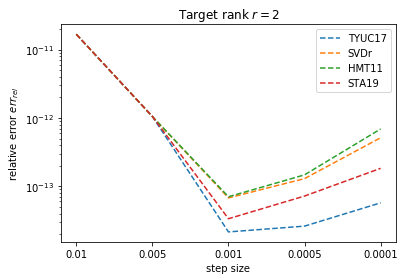

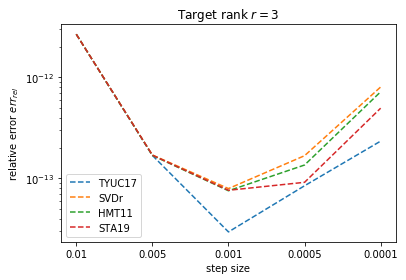

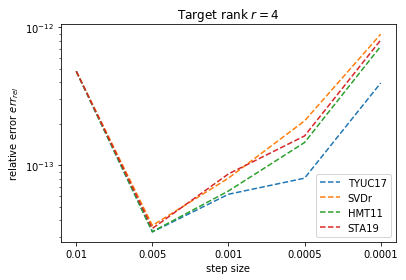

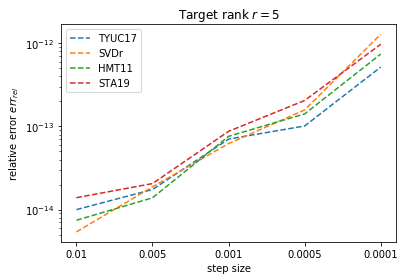

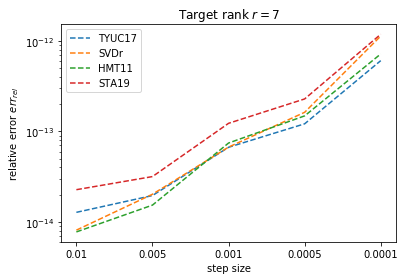

In [157]:
for r in range(5):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.semilogy(result[:,0,r],'--',label='TYUC17')
    plt.semilogy(result[:,1,r],'--',label='SVDr')
    plt.semilogy(result[:,2,r],'--',label='HMT11')
    plt.semilogy(result[:,3,r],'--',label='STA19')
    plt.legend()
    plt.title('Target rank $r=$'+str(r_array[r]))
    ax.set_xticks([0.0, 1.0, 2.0, 3.0, 4.0])
    ax.set_xticklabels(h_array)
    plt.xlabel('step size')
    plt.ylabel('relative error $err_{rel}$')